## Imports

In [2]:
#%pip install -U albumentations>=3.0.0
#!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

In [3]:
%cd /home/pso9kor/Documents/semanctic-segmentation-tasm/

/home/pso9kor/Documents/semanctic-segmentation-tasm


In [4]:
import tensorflow_advanced_segmentation_models as tasm
%cd ..

2023-07-11 11:12:35.815849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 11:12:35.926193: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 11:12:35.952128: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-11 11:12:36.510293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

/home/pso9kor/Documents


In [5]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from keras.utils import to_categorical
%matplotlib inline
import matplotlib.pyplot as plt

## Directories

In [5]:
# Data Handling
DATA_DIR = "/home/pso9kor/Datasets/cityscapes/"

x_train_dir = os.path.join(DATA_DIR, 'leftImg8bit/train')
y_train_dir = os.path.join(DATA_DIR, 'gtFine/train')

x_valid_dir = os.path.join(DATA_DIR, 'leftImg8bit/val')
y_valid_dir = os.path.join(DATA_DIR, 'gtFine/val')

x_test_dir = os.path.join(DATA_DIR, 'leftImg8bit/test')
y_test_dir = os.path.join(DATA_DIR, 'gtFine/test')

print(os.path.exists(x_train_dir))

True


In [6]:
def flatten(list):
    return [item for sublist in list for item in sublist]

def get_folders_in_folder(folder):
    return [f[0] for f in os.walk(folder)][1:]

def get_files_in_folder(folder, pattern=None):
    if pattern is None:
        return sorted([os.path.join(folder, f) for f in os.listdir(folder)])
    else:
        return sorted([os.path.join(folder, f) for f in os.listdir(folder) if pattern in f])

def get_files_recursive(folder, pattern=None):
    if not bool(get_folders_in_folder(folder)):
        return get_files_in_folder(folder, pattern)
    else:
        return flatten([get_files_in_folder(f, pattern) for f in get_folders_in_folder(folder)])

In [7]:
get_files_recursive(x_train_dir)[:2], get_files_recursive(y_train_dir, 'color')[:2]

(['/home/pso9kor/Datasets/cityscapes/leftImg8bit/train/monchengladbach/monchengladbach_000000_000076_leftImg8bit.png',
  '/home/pso9kor/Datasets/cityscapes/leftImg8bit/train/monchengladbach/monchengladbach_000000_000383_leftImg8bit.png'],
 ['/home/pso9kor/Datasets/cityscapes/gtFine/train/monchengladbach/monchengladbach_000000_000076_gtFine_color.png',
  '/home/pso9kor/Datasets/cityscapes/gtFine/train/monchengladbach/monchengladbach_000000_000383_gtFine_color.png'])

### Helper Functions

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

## Data Augmentation Functions

In [9]:
# define heavy augmentations
def get_training_augmentation(height, width):
    train_transform = [
        A.HorizontalFlip(p=0.3),

        # A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0.2, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        # A.RandomCrop(height=height, width=width, always_apply=True),
        A.Resize(height, width, always_apply=True),

        # A.GaussNoise(p=0.2),
        # A.Perspective(p=0.5),

        # A.OneOf(
        #     [
        #         A.CLAHE(p=1),
        #         A.RandomBrightnessContrast(p=1),
        #         A.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),

        # A.OneOf(
        #     [
        #         A.Sharpen(p=1),
        #         A.Blur(blur_limit=3, p=1),
        #         A.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

        # A.OneOf(
        #     [
        #         A.RandomContrast(p=1),
        #         A.HueSaturationValue(p=1),
        #     ],
        #     p=0.9,
        # ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(height, width):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(height, width),
        A.Resize(height, width, always_apply=True)
    ]
    return A.Compose(test_transform)

def data_get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

## Define the label classes

In [10]:
from collections import namedtuple

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,       19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [11]:
labels_color = [list(labels[k].color) for k in range(len(labels)) if labels[k].trainId >= 0 and labels[k].trainId < 255]
labels_name = [labels[k].name for k in range(len(labels)) if labels[k].trainId >= 0 and labels[k].trainId < 255]

print("Number of classes - ", len(labels_color))
for name, color in zip(labels_name, labels_color):
    print(f"{name} - {color}")

Number of classes -  20
unlabeled - [0, 0, 0]
road - [128, 64, 128]
sidewalk - [244, 35, 232]
building - [70, 70, 70]
wall - [102, 102, 156]
fence - [190, 153, 153]
pole - [153, 153, 153]
traffic light - [250, 170, 30]
traffic sign - [220, 220, 0]
vegetation - [107, 142, 35]
terrain - [152, 251, 152]
sky - [70, 130, 180]
person - [220, 20, 60]
rider - [255, 0, 0]
car - [0, 0, 142]
truck - [0, 0, 70]
bus - [0, 60, 100]
train - [0, 80, 100]
motorcycle - [0, 0, 230]
bicycle - [119, 11, 32]


## Define some global variables

In [12]:
TOTAL_CLASSES = labels_name
N_CLASSES = len(labels_color)
BATCH_SIZE = 4
HEIGHT = 256
WIDTH = 256
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"
WWO_AUG = True # train data with and without augmentation

## Data Generation Functions

In [13]:
def create_image_label_path_generator(images_dir, masks_dir, shuffle=False, seed=None):
    # ids = sorted(os.listdir(images_dir))
    # mask_ids = sorted(os.listdir(masks_dir))
    ids = get_files_recursive(images_dir)
    mask_ids = get_files_recursive(masks_dir, 'color')

    if shuffle == True:
        if seed is not None:
            tf.random.set_seed(seed)

        indices = tf.range(start=0, limit=tf.shape(ids)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        ids = tf.gather(ids, shuffled_indices).numpy().astype(str)
        mask_ids = tf.gather(mask_ids, shuffled_indices).numpy().astype(str)

    images_fps = [os.path.join(images_dir, image_id) for image_id in ids]
    masks_fps = [os.path.join(masks_dir, image_id) for image_id in mask_ids]

    while True:
        for i in range(len(images_fps)):
            yield [images_fps[i], masks_fps[i]]

In [14]:
def label_segmentation_mask(seg, class_labels):
    """
    Given a 3D (W, H, depth=3) segmentation mask, prepare a 2D labeled segmentation mask

    # Arguments
        seg: The segmentation mask where each cell of depth provides the r, g, and b values
        class_labels

    # Returns
        Labeled segmentation mask where each cell provides its label value
    """
    seg = seg.astype("uint8")

    # returns a 2D matrix of size W x H of the segmentation mask
    label = np.zeros(seg.shape[:2], dtype=np.uint8)

    for i, rgb in enumerate(class_labels):
        label[(seg == rgb).all(axis=2)] = i
    return label

def one_hot_encode(seg, class_labels):
    """
    Convert a segmentation mask label array to one-hot format
    by replacing each pixel value with a vector of length num_classes

    # Arguments
        seg: The 3D array segmentation mask
        class_labels

    # Returns
        A 3D array with the same width and height as the input, but
        with a depth size of num_classes
    """
    num_classes = len(class_labels)  # seg dim = H*W*3
    label = label_segmentation_mask(seg, class_labels)  # label dim = H*W
    one_hot = to_categorical(label, num_classes)  # one_hot dim = H*W*N
    return one_hot

def decode_one_hot(label_one_hot, labels_name):
    pred = np.argmax(label_one_hot, axis=-1)
    color_codes = np.array(labels_name)
    pred = color_codes[pred.astype(np.uint8)]
    return pred

In [15]:
def process_image_label(images_paths, masks_paths, class_labels, augmentation=None):
    # read data
    image = cv2.imread(images_paths)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_paths)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    # apply augmentations
    if augmentation:
        sample = augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    mask_one_hot = one_hot_encode(mask, class_labels)
    return image, mask, mask_one_hot

2023-07-10 19:16:05.892203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 19:16:06.338863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19299 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


/home/pso9kor/Datasets/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000182_000019_leftImg8bit.png /home/pso9kor/Datasets/cityscapes/gtFine/train/dusseldorf/dusseldorf_000182_000019_gtFine_color.png
(1024, 2048, 3) (1024, 2048, 3) (256, 256, 3) (256, 256, 3) (256, 256, 20)


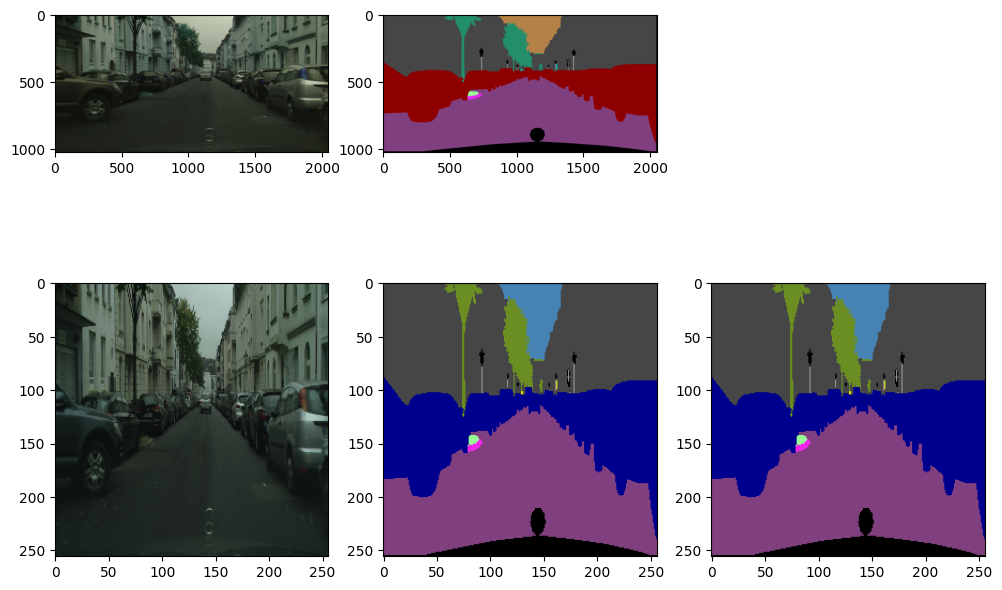

In [16]:
image_label_path_generator = create_image_label_path_generator(x_train_dir, y_train_dir, shuffle=True, seed=None)
image_path, label_path = next(image_label_path_generator)

print(image_path, label_path)

image = cv2.imread(image_path)
mask = cv2.imread(label_path)
image_aug, label_aug, label_one_hot = process_image_label(image_path, label_path, labels_color, augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH))

print(image.shape, mask.shape, image_aug.shape, label_aug.shape, label_one_hot.shape)

fig = plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.subplot(2, 3, 2)
plt.imshow(mask)
plt.subplot(2, 3, 4)
plt.imshow(image_aug)
plt.subplot(2, 3, 5)
plt.imshow(label_aug)
plt.subplot(2, 3, 6)
plt.imshow(decode_one_hot(label_one_hot, labels_color))
plt.show()

In [17]:
################################################################################################
# Data Generator
################################################################################################
def DataGenerator(train_dir, label_dir, batch_size, height, width, class_labels, augmentation, wwo_aug=False, shuffle=False, seed=None):
    image_label_path_generator = create_image_label_path_generator(
        train_dir, label_dir, shuffle=shuffle, seed=seed
    )
    if wwo_aug:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            labels = np.zeros(shape=[batch_size, height, width, len(class_labels)], dtype=np.float32)
            for i in range(0, batch_size, 2):
                image_path, label_path = next(image_label_path_generator)
                image_aug, label_aug, label_aug_oh = process_image_label(image_path, label_path, class_labels, augmentation=augmentation)
                image_wo_aug, label_wo_aug, label_wo_aug_oh = process_image_label(image_path, label_path, class_labels, 
                                                                                  augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH))
                images[i], labels[i] = image_aug, label_aug_oh
                images[i + 1], labels[i + 1] = image_wo_aug, label_wo_aug_oh

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)
    else:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            labels = np.zeros(shape=[batch_size, height, width, len(class_labels)], dtype=np.float32)
            for i in range(batch_size):
                image_path, label_path = next(image_label_path_generator)
                image, label, label_oh = process_image_label(image_path, label_path, class_labels, augmentation=augmentation)
                images[i], labels[i] = image, label_oh

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)

## Create the Model

In [18]:
BACKBONE_NAME

'efficientnetb3'

In [19]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.DANet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

### Define the optimizer as well as losses, metrics and callbacks

In [20]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = False

callbacks = [
             tf.keras.callbacks.ModelCheckpoint("model.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

### Get the Data

<p>There are three options for the training dataset: </p>

- Training without augmentation
- Training with augmentation
- Training with and without augmentation (twice the data)

<p>Validation and Test data are of course without augmentation</p>

In [21]:
train_shuffle = True
val_shuffle = True
seed = 29598

##########################################################################################################
# Data Generator
#           augmentation - wwo_aug
# get_train_augmentation -  true    -   both (training) and (validation) augmentation   - TrainSetwwoAug
# get_train_augmentation -  false   -   only (training) augmentation                    - TrainSet
# get_valid_augmentation -  true    -   both (validation) and (validation) augmentation - xx
# get_valid_augmentation -  false   -   only (validation) augmentation                  - TrainSetwoAug, ValidationSet, TestSet
##########################################################################################################
TrainSet = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    labels_color,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    shuffle=train_shuffle,
    seed=seed
    )

TrainSetwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    labels_color,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    shuffle=train_shuffle,
    seed=seed
)

TrainSetwwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    labels_color,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    wwo_aug=True,
    shuffle=train_shuffle,
    seed=seed
)

ValidationSet = DataGenerator(
    x_valid_dir,
    y_valid_dir,
    1,
    HEIGHT,
    WIDTH,
    labels_color,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    shuffle=val_shuffle,
    seed=seed
)

TestSet = DataGenerator(
    x_test_dir,
    y_test_dir,
    1,
    HEIGHT,
    WIDTH,
    labels_color,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
)

for i in TrainSet:
    sample_image, sample_mask = i[0][0], i[1][0]
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

2
(4, 256, 256, 3)
(4, 256, 256, 20)


In [22]:
n_samples_train = len(get_files_recursive(x_train_dir))
n_samples_valid = len(get_files_recursive(x_valid_dir))
n_samples_test = len(get_files_recursive(x_test_dir))

n_samples_train, n_samples_valid, n_samples_test

(2975, 500, 1525)

<p>Short check if model works properly.</p>

2023-07-10 19:16:38.827161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-07-10 19:16:40.465138: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-07-10 19:16:40.466350: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-07-10 19:16:40.466364: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-07-10 19:16:40.466422: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

(1, 256, 256, 20)
(256, 256, 1)
SparseCategoricalCrossentroy: 3.2207885
Iou-Score: 0.022198483
categorical Focal Dice Loss: 0.9936692


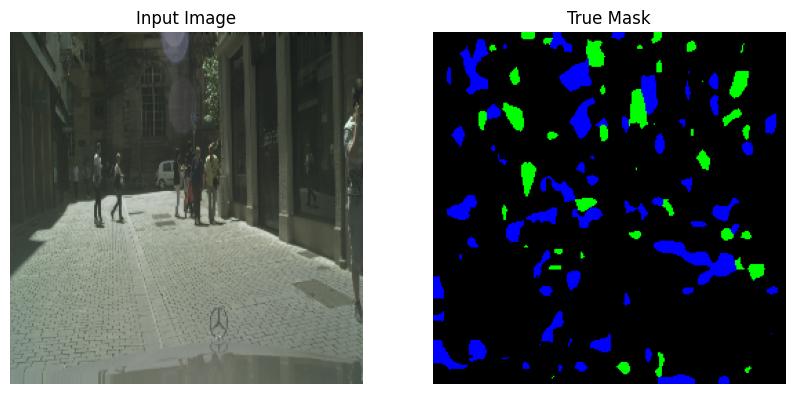

In [23]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    output_model = model(sample_image[tf.newaxis, ...])
    print(output_model.shape)
    
    output_mask = create_mask(output_model)
    print(output_mask.shape)

    scce = tf.keras.losses.CategoricalCrossentropy()
    print("SparseCategoricalCrossentroy: " + str(scce(sample_mask, output_model[0]).numpy()))
    print("Iou-Score: " + str(tasm.losses.iou_score(sample_mask, output_model[0]).numpy()))
    print("categorical Focal Dice Loss: " + str(categorical_focal_dice_loss(sample_mask, output_model[0]).numpy()))

    display([sample_image, K.one_hot(K.squeeze(output_mask, axis=-1), 3)])
    
show_predictions()

In [24]:
model.summary()

Model: "da_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  multiple                 0         
 )                                                               
                                                                 
 model (Functional)          [(None, 128, 128, 144),   184645    
                              (None, 64, 64, 192),               
                              (None, 32, 32, 288)]               
                                                                 
 convolution_bn_activation (  multiple                 664832    
 ConvolutionBnActivation)                                        
                                                                 
 convolution_bn_activation_1  multiple                 664832    
  (ConvolutionBnActivation)                                      
                                                            

# Training

#### Training Procedure
##### 1) Train model with freezed backbone only on train data
##### 2) Train completly unfreezed model with train and validation data

### 1) Train model with freezed backbone only on train data

<p>Set Backbone trainable to False.</p>

In [25]:
model.layers

In [26]:
for layer in model.layers:
    if "model" in layer.name:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))

up_sampling2d: True
model: False
convolution_bn_activation: True
convolution_bn_activation_1: True
pam__module: True
cam__module: True
convolution_bn_activation_5: True
convolution_bn_activation_6: True
dropout: True
dropout_1: True
dropout_2: True
convolution_bn_activation_7: True
convolution_bn_activation_8: True
convolution_bn_activation_9: True
concatenate_1: True
concatenate_2: True
convolution_bn_activation_10: True


In [27]:
steps_per_epoch = np.floor(n_samples_train / BATCH_SIZE)

print(BATCH_SIZE, steps_per_epoch)

4 743.0


In [28]:
history = model.fit(
    TrainSet,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    callbacks=callbacks,
    )

Epoch 1/10
743/743 [==============================] - 362s 481ms/step - loss: 0.7621 - iou_score: 0.4846 - lr: 0.2000
Epoch 2/10
743/743 [==============================] - 323s 435ms/step - loss: 0.7270 - iou_score: 0.4717 - lr: 0.2000
Epoch 3/10
743/743 [==============================] - 320s 430ms/step - loss: 0.7185 - iou_score: 0.4504 - lr: 0.2000
Epoch 4/10
743/743 [==============================] - 320s 430ms/step - loss: 0.7132 - iou_score: 0.4410 - lr: 0.2000
Epoch 5/10
743/743 [==============================] - 318s 428ms/step - loss: 0.7093 - iou_score: 0.4373 - lr: 0.2000
Epoch 6/10
743/743 [==============================] - 317s 427ms/step - loss: 0.7051 - iou_score: 0.4421 - lr: 0.2000
Epoch 7/10
743/743 [==============================] - ETA: 0s - loss: 0.7024 - iou_score: 0.4440WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.04000000059604645.
743/743 [==============================] -

### Plot Training IoU Scores and Losses

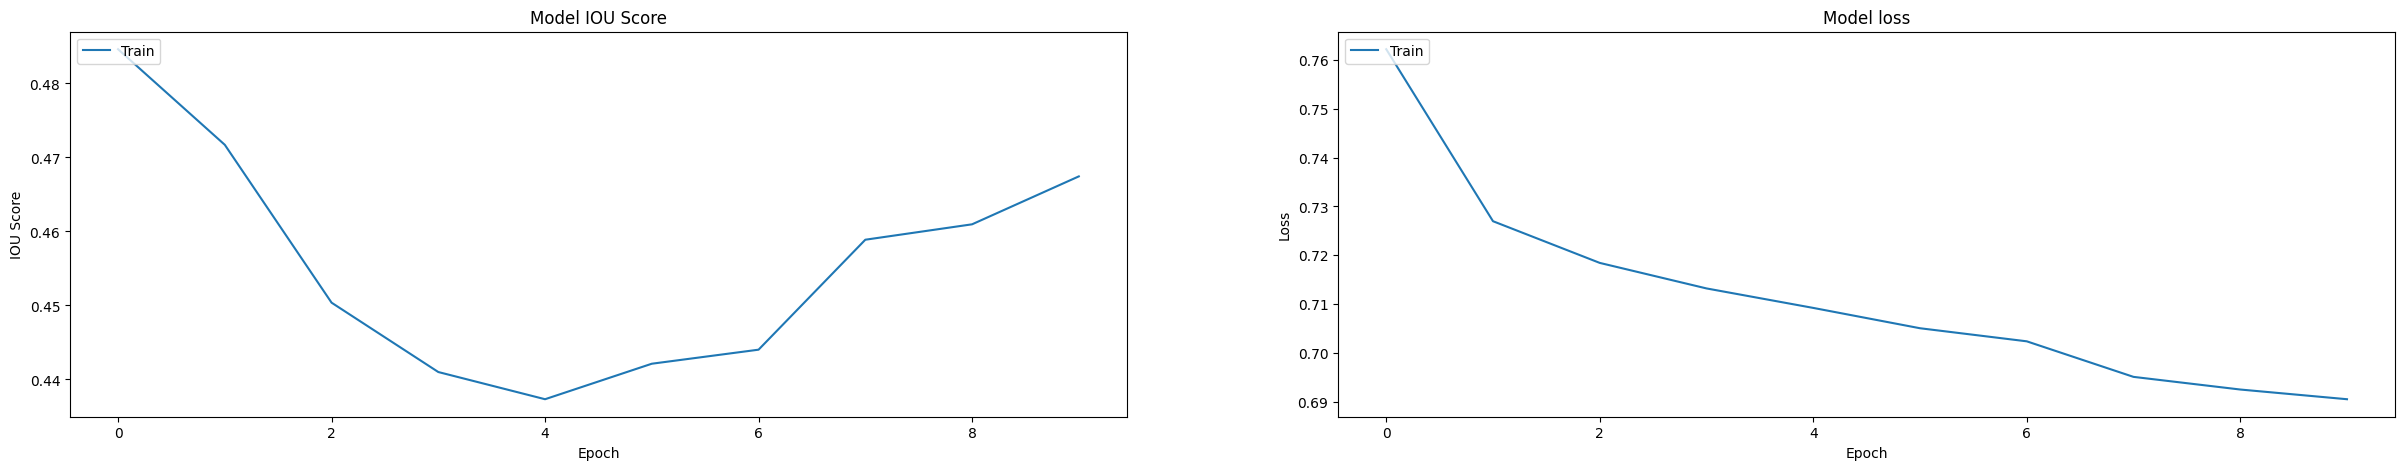

In [29]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

2) Train completly unfreezed model with train and test data

<p>Make whole model trainable and use validation set.</p>

In [30]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

up_sampling2d: True
model: True
convolution_bn_activation: True
convolution_bn_activation_1: True
pam__module: True
cam__module: True
convolution_bn_activation_5: True
convolution_bn_activation_6: True
dropout: True
dropout_1: True
dropout_2: True
convolution_bn_activation_7: True
convolution_bn_activation_8: True
convolution_bn_activation_9: True
concatenate_1: True
concatenate_2: True
convolution_bn_activation_10: True


In [31]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [32]:
history = model.fit(
    TrainSetwwoAug,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    callbacks=callbacks,
    validation_data=ValidationSet,
    validation_steps=len(os.listdir(x_valid_dir)),
    )

Epoch 1/30
743/743 [==============================] - ETA: 0s - loss: 0.7044 - iou_score: 0.4273
Epoch 1: val_loss improved from inf to 0.78477, saving model to DeepLabV3plus.ckpt
743/743 [==============================] - 341s 459ms/step - loss: 0.7044 - iou_score: 0.4273 - val_loss: 0.7848 - val_iou_score: 0.4789 - lr: 0.1000
Epoch 2/30
743/743 [==============================] - ETA: 0s - loss: 0.6966 - iou_score: 0.4451
Epoch 2: val_loss improved from 0.78477 to 0.72196, saving model to DeepLabV3plus.ckpt
743/743 [==============================] - 339s 457ms/step - loss: 0.6966 - iou_score: 0.4451 - val_loss: 0.7220 - val_iou_score: 0.4200 - lr: 0.1000
Epoch 3/30
743/743 [==============================] - ETA: 0s - loss: 0.6922 - iou_score: 0.4556
Epoch 3: val_loss improved from 0.72196 to 0.69553, saving model to DeepLabV3plus.ckpt
743/743 [==============================] - 339s 457ms/step - loss: 0.6922 - iou_score: 0.4556 - val_loss: 0.6955 - val_iou_score: 0.4109 - lr: 0.1000
Ep

### Plot Training IoU Scores and Losses

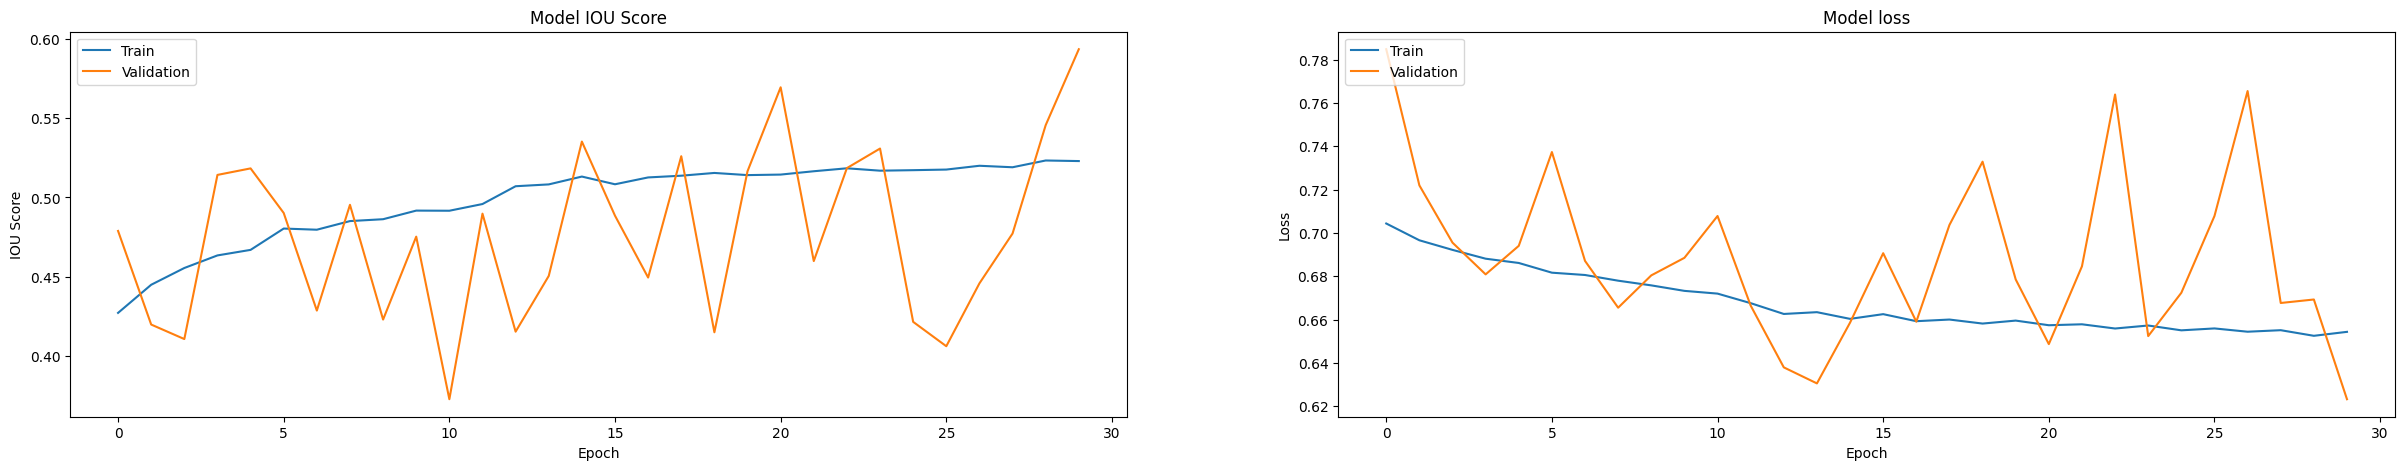

In [33]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation on Test Data

In [34]:
scores = model.evaluate(TestSet, steps=101)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    if metric != "accuracy":
        metric = metric.__name__
    print("mean {}: {:.5}".format(metric, value))

101/101 [==============================] - 13s 132ms/step - loss: 1.1107 - iou_score: 0.2986
Loss: 1.1107
mean iou_score: 0.2986


## Visual Examples on Test Data

In [37]:
counter

3

1/1 [==============================] - 0s 81ms/step


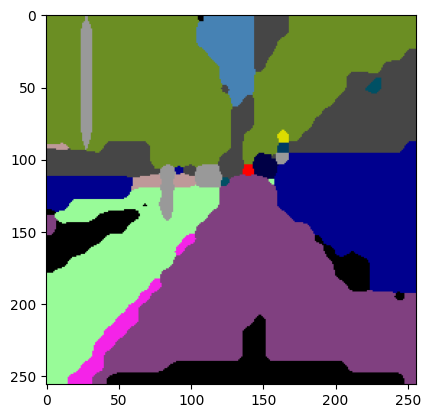

In [42]:
plt.imshow(decode_one_hot(model.predict(image)[0], labels_color))
plt.show()

In [41]:
model.predict(image)[0].shape

1/1 [==============================] - 0s 78ms/step


(256, 256, 20)

In [40]:
pr_mask.shape

(1, 256, 256)

[ 3 97 88  9 74]
1/1 [==============================] - 0s 77ms/step
3


TypeError: Invalid shape (256, 256, 20) for image data

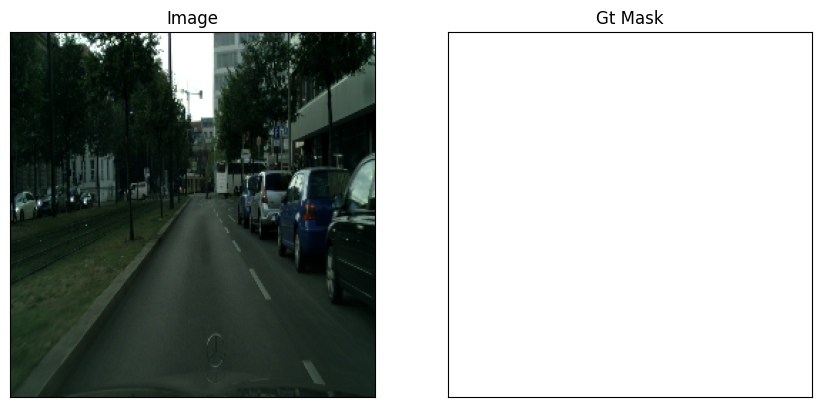

In [35]:
n = 5
ids = np.random.choice(np.arange(101), size=n,replace=False)
print(ids)

counter = 0
second_counter = 0
for i in TestSet:
    if counter in ids:
        image, gt_mask = i
        # image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)
        pr_mask = np.argmax(pr_mask, axis=-1)

        print(counter)
        
        visualize(
            image=denormalize(image.numpy().squeeze()),
            gt_mask=gt_mask.numpy().squeeze(),
            pr_mask=pr_mask.squeeze(),
        )
        second_counter += 1
    counter += 1
    if second_counter == n:
        break